# MNIST VAE Test

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torchvision
import os
%matplotlib inline

# Get CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# get pytorch version
version = torch.__version__
print("Pytorch version: {}".format(version))

Pytorch version: 2.0.1


In [12]:

# VAE Definition
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Hyperparameters
epochs = 10
batch_size = 128
learning_rate = 1e-5

# Data Loaders
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize VAE and optimizer
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Load the model
if os.path.exists("vae_mnist.pth"):
    model.load_state_dict(torch.load("vae_mnist.pth"))

# Training loop
model.train()
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Save the model
torch.save(model.state_dict(), "vae_mnist_v1.pth")

Train Epoch: 0 [0/60000 (0%)]	Loss: 230.236160
Train Epoch: 0 [12800/60000 (21%)]	Loss: 213.733765
Train Epoch: 0 [25600/60000 (43%)]	Loss: 186.901978
Train Epoch: 0 [38400/60000 (64%)]	Loss: 173.060165
Train Epoch: 0 [51200/60000 (85%)]	Loss: 160.873306
====> Epoch: 0 Average loss: 188.0239
Train Epoch: 1 [0/60000 (0%)]	Loss: 154.011139
Train Epoch: 1 [12800/60000 (21%)]	Loss: 152.401291
Train Epoch: 1 [25600/60000 (43%)]	Loss: 143.126907
Train Epoch: 1 [38400/60000 (64%)]	Loss: 141.195526
Train Epoch: 1 [51200/60000 (85%)]	Loss: 133.236588
====> Epoch: 1 Average loss: 142.9876
Train Epoch: 2 [0/60000 (0%)]	Loss: 135.675354
Train Epoch: 2 [12800/60000 (21%)]	Loss: 139.177826
Train Epoch: 2 [25600/60000 (43%)]	Loss: 136.717407
Train Epoch: 2 [38400/60000 (64%)]	Loss: 126.831848
Train Epoch: 2 [51200/60000 (85%)]	Loss: 124.960068
====> Epoch: 2 Average loss: 130.3978
Train Epoch: 3 [0/60000 (0%)]	Loss: 123.633438
Train Epoch: 3 [12800/60000 (21%)]	Loss: 123.922356
Train Epoch: 3 [25600/

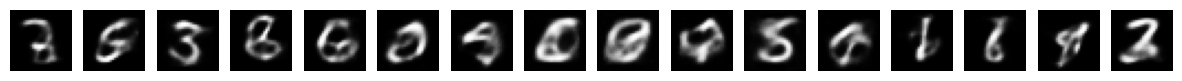

In [13]:

# Load the model (optional if you just want to use the trained model right away)
#model.load_state_dict(torch.load("vae_mnist.pth"))
#model.eval()

import matplotlib.pyplot as plt

def sample_from_random_points(model, num_samples=16):
    with torch.no_grad():
        # Generate random latent vectors
        z = torch.randn(num_samples, 20)
        samples = model.decode(z)
    return samples.view(-1, 28, 28)

# Generate samples
num_samples = 16
samples = sample_from_random_points(model, num_samples)
fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))
for ax, img in zip(axes, samples):
    ax.imshow(img.cpu().numpy(), cmap='gray')
    ax.axis('off')
plt.show()


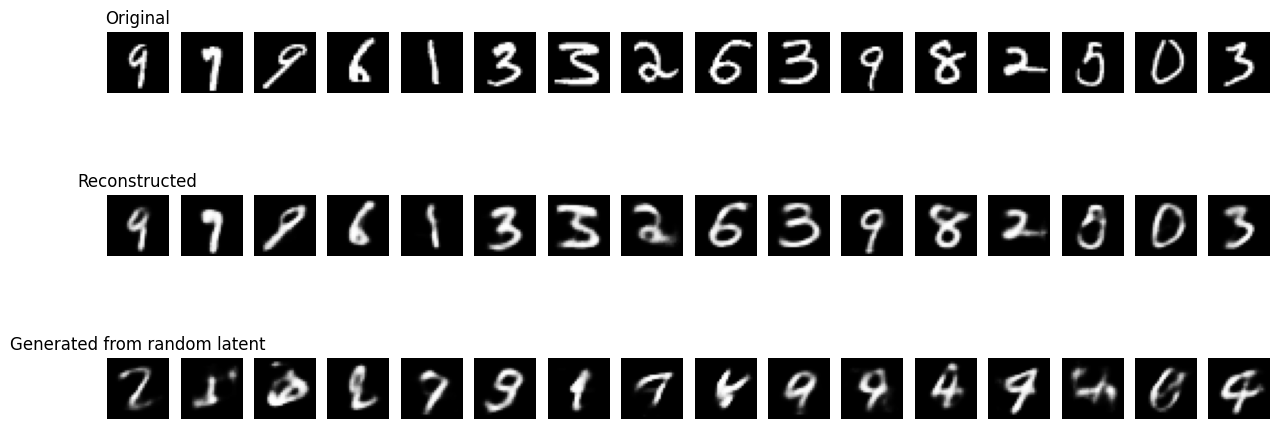

In [5]:

# Function to visualize original, reconstructed, and generated samples
def visualize_results(model, data_loader, num_samples=16):
    model.eval()
    
    # Get a batch of real data
    data, _ = next(iter(data_loader))
    data = data[:num_samples]

    # Reconstruct data
    with torch.no_grad():
        recon, _, _ = model(data)

    # Generate from random latent vectors
    z = torch.randn(num_samples, 20)
    generated_samples = model.decode(z)

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

    for ax, img, recon_img, gen_img in zip(axes.T, data, recon, generated_samples):
        ax[0].imshow(img[0].cpu().numpy(), cmap='gray')
        ax[1].imshow(recon_img.view(28, 28).cpu().numpy(), cmap='gray')
        ax[2].imshow(gen_img.view(28, 28).detach().cpu().numpy(), cmap='gray')

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

    axes[0, 0].set_title('Original')
    axes[1, 0].set_title('Reconstructed')
    axes[2, 0].set_title('Generated from random latent')

    plt.show()

visualize_results(model, train_loader)


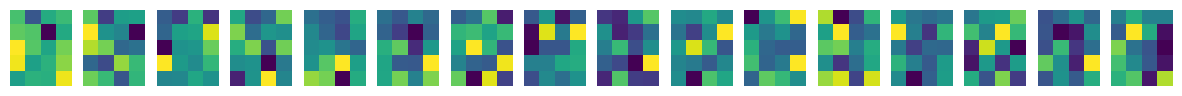

In [6]:
# Function to visualize the latents
def visualize_latents(model, data_loader, num_samples=16):
    model.eval()
    
    # Get a batch of real data
    data, _ = next(iter(data_loader))
    data = data[:num_samples]

    # Get latent vectors
    with torch.no_grad():
        _, mu, _ = model(data)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 6))

    for ax, latent in zip(axes, mu):
        # Rescale values between 0 and 1 for visualization
        img = (latent - latent.min()) / (latent.max() - latent.min())
        ax.imshow(img.view(5, 4).cpu().numpy(), cmap='viridis')
        ax.axis('off')

    plt.show()

visualize_latents(model, train_loader)
